# Used car's price prediction


**Цель исследования** - разработанная модель предсказания стоимости автомобиля на вторичном рынке.

**Основные этапы исследования:**

- загрузка и ознакомление с данными,
- предварительная обработка,
- разведочный анализ,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

**Описание данных**

Признаки:

- 'year' - год производства
- 'make' - производитель
- 'model' - модель
- 'trim' - модификация
- 'body' - тип кузова
- 'transmission' - тип КПП
- 'vin' - идентификатор (вин)
- 'state' - штат регистрации
- 'condition' - состояние по шкале (1-5)
- 'odometer' - пробег в милях
- 'color' - цвет кузова
- 'interior' - цвет интерьера
- 'seller' - продавец
- 'saledate' - дата продажи 

Целевой признак:

- 'sellingprice' - стоимость продажи


## Обзор данных

### Подключение необходимых библиотек

In [1]:
pip install optuna

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
from lightgbm import LGBMRegressor

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    mean_squared_log_error

from catboost import CatBoostRegressor
import shap

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

import warnings

warnings.filterwarnings("ignore")

RAND = 10
N_FOLDS = 3

### Открытие и изучение данных

In [4]:
server_path = '/datasets/'
local_path = ''
train = 'train.csv'
test = 'test.csv'
ss = 'sample_submission.csv'

try:
    train = pd.read_csv(server_path + train)  
    test = pd.read_csv(server_path + test)
    ss = pd.read_csv(server_path + ss)
except: 
    train = pd.read_csv(local_path + train)  
    test = pd.read_csv(local_path + test)
    ss = pd.read_csv(local_path + ss)

In [5]:
train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [6]:
test.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [7]:
ss.head(5)

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


In [10]:
def unique_check(data):
    columns = data.columns
    for c in columns:
        print(c.upper(), '\n', data[c].unique(), '\n')

In [11]:
unique_check(train)

YEAR 
 [2011 2014 2012 2003 2007 2013 2010 2000 2005 2006 2004 2008 2009 2015
 2002 2001 1999 1998 1996 1997 1994 1995 1993 1989 1991 1988 1987 1990
 1992 1985 1986 1983 1984 1982] 

MAKE 
 ['Ford' 'Nissan' 'HUMMER' 'Lincoln' 'pontiac' 'Hyundai' nan 'Buick'
 'Chevrolet' 'Honda' 'Acura' 'Cadillac' 'GMC' 'Saab' 'Dodge'
 'Mercedes-Benz' 'Toyota' 'Volkswagen' 'BMW' 'Infiniti' 'Chrysler' 'Kia'
 'Jaguar' 'Subaru' 'Jeep' 'Lexus' 'mercedes' 'Scion' 'FIAT' 'Suzuki'
 'Mazda' 'Volvo' 'Audi' 'MINI' 'Isuzu' 'Mitsubishi' 'smart' 'Pontiac'
 'Porsche' 'subaru' 'ford' 'Land Rover' 'chrysler' 'Saturn' 'mazda'
 'dodge' 'Ram' 'Oldsmobile' 'hyundai' 'Mercury' 'Bentley' 'toyota'
 'lincoln' 'Fisker' 'nissan' 'chevrolet' 'honda' 'porsche' 'mitsubishi'
 'lexus' 'bmw' 'Maserati' 'acura' 'jeep' 'mercury' 'Tesla' 'landrover'
 'vw' 'cadillac' 'buick' 'gmc truck' 'land rover' 'volkswagen'
 'Rolls-Royce' 'audi' 'Ferrari' 'suzuki' 'Plymouth' 'oldsmobile'
 'Lamborghini' 'gmc' 'Geo' 'ford truck' 'Aston Martin' 'plymout

BODY 
 ['suv' 'Sedan' 'sedan' nan 'SUV' 'wagon' 'Minivan' 'Extended Cab'
 'Regular Cab' 'Coupe' 'SuperCrew' 'Wagon' 'convertible' 'Crew Cab'
 'SuperCab' 'Convertible' 'Hatchback' 'minivan' 'hatchback' 'G Coupe'
 'G Convertible' 'coupe' 'Access Cab' 'G Sedan' 'regular cab'
 'e-series van' 'supercrew' 'Quad Cab' 'tsx sport wagon' 'Van' 'g sedan'
 'E-Series Van' 'CTS Coupe' 'Koup' 'King Cab' 'extended cab' 'double cab'
 'Elantra Coupe' 'koup' 'access cab' 'Double Cab' 'crew cab' 'quad cab'
 'g coupe' 'CrewMax Cab' 'supercab' 'g convertible' 'Genesis Coupe' 'van'
 'G37 Coupe' 'club cab' 'Beetle Convertible' 'Mega Cab' 'regular-cab'
 'Xtracab' 'cts coupe' 'genesis coupe' 'Club Cab' 'q60 coupe' 'mega cab'
 'crewmax cab' 'Promaster Cargo Van' 'king cab' 'CTS-V Coupe'
 'TSX Sport Wagon' 'CTS Wagon' 'Cab Plus 4' 'G37 Convertible'
 'Transit Van' 'Q60 Convertible' 'elantra coupe' 'beetle convertible'
 'Q60 Coupe' 'promaster cargo van' 'Cab Plus' 'transit van'
 'g37 convertible' 'g37 coupe' 'Ram V

In [12]:
unique_check(test)

YEAR 
 [2005 2014 2013 2003 2011 2007 2015 2009 2012 2010 2006 2001 2002 2008
 2004 2000 1997 1998 1999 1995 1996 1992 1993 1991 1994 1986 1989 1990
 1982 1984 1987] 

MAKE 
 ['Cadillac' 'GMC' 'Nissan' 'Chevrolet' 'Volkswagen' 'Hyundai' 'Ford'
 'Infiniti' 'Subaru' 'Kia' 'BMW' nan 'Mitsubishi' 'Dodge' 'Oldsmobile'
 'Volvo' 'Pontiac' 'Acura' 'Honda' 'Toyota' 'Audi' 'Jeep' 'Lincoln'
 'Chrysler' 'Mercedes-Benz' 'Ram' 'Scion' 'Mercury' 'Lexus' 'Saturn'
 'Mazda' 'Porsche' 'MINI' 'smart' 'Buick' 'HUMMER' 'ford' 'chrysler'
 'Jaguar' 'mitsubishi' 'FIAT' 'Saab' 'mazda' 'Suzuki' 'Land Rover' 'bmw'
 'cadillac' 'oldsmobile' 'honda' 'acura' 'buick' 'landrover' 'Geo' 'lexus'
 'dodge' 'chevrolet' 'chev truck' 'nissan' 'Bentley' 'jeep' 'mercury'
 'toyota' 'gmc' 'Isuzu' 'Aston Martin' 'Maserati' 'land rover' 'kia'
 'subaru' 'Daewoo' 'vw' 'volkswagen' 'Tesla' 'mercedes' 'Ferrari'
 'hyundai' 'pontiac' 'Fisker' 'porsche' 'Rolls-Royce' 'Lotus' 'Plymouth'
 'hyundai tk' 'lincoln' 'ford tk' 'audi'] 

MODEL 
 [

В данных обнаружены пропуски и неявные дубликаты. 

### Подготовка данных

В девяти столбцах обнаружены пропуски, заполним их значением 'unkn' для категориальных данных и медианным значением в столбце 'odometer'.

In [13]:
columns = ['make', 'model', 'trim', 'body', 'transmission', 'interior', 'color']
for c in columns:
    train[c] = train[c].fillna('unkn')
    test[c] = test[c].fillna('unkn')
train['odometer'] = train.fillna(train['odometer'].median())
train['condition'] = train.fillna(train['condition'].median())
test['odometer'] = test.fillna(test['odometer'].median())

Разделим дату продажи на день, месяц и год для удобства обучения модели.

In [14]:
train['saledate'] = pd.to_datetime(train['saledate'], utc=True)
test['saledate'] = pd.to_datetime(test['saledate'], utc=True)

train["saleyear"] = pd.DatetimeIndex(train["saledate"]).year
train["salemonth"] = pd.DatetimeIndex(train["saledate"]).month
train["saleday"] = pd.DatetimeIndex(train["saledate"]).day

test["saleyear"] = pd.DatetimeIndex(test["saledate"]).year
test["salemonth"] = pd.DatetimeIndex(test["saledate"]).month
test["saleday"] = pd.DatetimeIndex(test["saledate"]).day

train = train.drop('saledate', axis=1)
test = test.drop('saledate', axis=1)

Приведем значения столбцов к нижнему регистру.

In [15]:
columns = ['make', 'model', 'trim', 'body']
for c in columns:
    train[c] = train[c].str.lower()
    test[c] = test[c].str.lower()


Уменьшим количество неявных дубликатов.

In [16]:
train = train.replace(['mercedes-benz', 'mercedes-b', 'land rover', 'vw', 'dodge tk', 'ford truck', 'gmc truck', 'mazda tk','hyundai tk', 'ford tk', 'chev truck'], ['mercedes', 'mercedes', 'landrover', 'volkswagen', 'dodge', 'ford', 'gmc', 'mazda', 'hyundai', 'ford','chevrolet'])
test = test.replace(['mercedes-benz', 'mercedes-b', 'land rover', 'vw', 'dodge tk', 'ford truck', 'gmc truck', 'mazda tk','hyundai tk', 'ford tk', 'chev truck'], ['mercedes', 'mercedes', 'landrover', 'volkswagen', 'dodge', 'ford', 'gmc', 'mazda', 'hyundai', 'ford','chevrolet'])

In [ ]:
# Пробовала выделять trucks как отдельный признак, модель показала себя хуже.

# l = ['dodge tk', 'ford truck', 'gmc truck', 'mazda tk','hyundai tk', 'ford tk', 'chev truck', ]
# nc = []
# nct = []
# for i in range(0, len(train['make'])):
#    if train['make'][i] in l:
#        nc.append('tk')
#    else:
#        nc.append('not tk')
# for i in range(0, len(test['make'])):
#    if test['make'][i] in l:
#        nct.append('tk')
#    else:
#        nct.append('not tk')

# В первой попытке не стала удалять vin в тестовой и обучающей выборке,
# потом удалила, качество модели тоже снизилось, поэтому все-таки оставила.

# train = train.drop('vin', axis=1)

Проверим наличие явных дубликатов.

In [17]:
train.duplicated().sum()

0

In [18]:
test.duplicated().sum()

0

In [19]:
train['sellingprice'].describe()

count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

В данных есть выбросы. Просмотрим строки с максимальным значением столбца price.

In [20]:
train.query('sellingprice > 100000')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saleyear,salemonth,saleday
3046,2014,mercedes,g-class,g63 amg,suv,automatic,wdcyc7df6ex216753,ca,2014,2014,charcoal,black,chings trading,134000,2014,12,18
6464,2013,bentley,continental gtc,base,convertible,automatic,scbgu3za2dc084880,ga,2013,2013,gray,tan,porsche fin svcs dba bentley financial services,130500,2015,5,26
9787,2013,mercedes,g-class,g63 amg,suv,automatic,wdcyc7df5dx202289,ca,2013,2013,gray,black,honda of pasadena,109000,2015,2,11
12304,2014,audi,rs 7,prestige quattro,sedan,automatic,wuaw2afc7en902024,ca,2014,2014,black,black,kawo int'l inc,105000,2014,12,18
13149,2014,bmw,i8,base,coupe,automatic,wby2z2c50evx64103,ca,2014,2014,white,beige,high bid trading co inc,158000,2015,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427614,2012,ferrari,california,base,convertible,automatic,zff65tja4c0187060,fl,2012,2012,gray,black,the collection,138000,2015,5,27
431767,2014,landrover,range rover,supercharged,suv,automatic,salgs2ef7ea152790,ca,2014,2014,black,black,high bid trading co inc,104000,2015,2,11
432735,2010,bentley,continental supersports,base,coupe,automatic,scbcu8za2ac064118,ca,2010,2010,red,black,jn group inc,101000,2015,1,28
438781,2014,landrover,range rover,supercharged,suv,automatic,salgs2ef7ea152398,ca,2014,2014,black,black,land rover north america llc,110000,2015,1,14


Максимальные значения у таких марок, как феррари, ауди, мерседес. Похоже на правду, оставим как есть.

Изменим типы данных для дальнейшего обучения моделей.

In [21]:
cols_cat = train.select_dtypes(['object']).columns
train[cols_cat] = train[cols_cat].astype('category')

Разделим датасет на обучающую, валидационную и тестовую выборку.

In [22]:
X = train.drop(['sellingprice'], axis=1)
y = train['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    random_state=RAND)

eval_set = [(X_val, y_val)]

Проведем кодировку категориальных данных и масштабирование числовых.

In [23]:
transformers_list = [
    ('encode', OneHotEncoder(dtype='int', handle_unknown = 'ignore'), [
        'make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']),
    ('scale', StandardScaler(),
     ['saleyear', 'salemonth', 'saleday', 'condition', 'odometer'])
]

column_transformer = ColumnTransformer(transformers_list)

### Обучение модели

Функция получения значений метрик:

In [24]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics['RMSLE'] = rmsle(y_test, y_pred)
    df_metrics['R2 adjusted'] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics['MPE_%'] = mpe(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)

    return df_metrics


#### baseline

In [25]:
pipe = Pipeline([('columnTransformer', column_transformer),
                 ('lr', LinearRegression())])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [26]:
metrics = get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,2358.143201,1.279424e+07,3576.90423,None,0.865404,4.691198,51.371767,17.324764


#### CatBoostRegressor

In [27]:
cat_features = X_val.select_dtypes('category').columns.tolist()


# здесь и далее ключевая метрика mae. 
# я не разобралась, почему, при установлении mape
# значение mape наоборот растет

cb = CatBoostRegressor(random_seed=RAND,
                       loss_function='MAE', 
                       eval_metric='MAE',
                       cat_features=cat_features,
                       allow_writing_files=False)

eval_set = [(X_val, y_val)]

cb.fit(X_train_,
       y_train_,
       eval_set=eval_set,
       verbose=0,
       early_stopping_rounds=100)

y_pred_cb = cb.predict(X_test)

In [28]:
metrics = metrics.append(
    get_metrics(y_test, y_pred_cb, X_test, 'CatBoostRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,2358.143201,1.279424e+07,3576.904230,None,0.865404,4.691198,51.371767,17.324764
0,CatBoostRegressor_baseline,2010.397787,1.433766e+07,3786.510267,None,0.849168,-9.227455,24.346856,14.769955


#### LGBMRegressor

In [29]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')
lgb.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = lgb.predict(X_test)

In [30]:
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'LGBMRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,2358.143201,1.279424e+07,3576.904230,None,0.865404,4.691198,51.371767,17.324764
0,CatBoostRegressor_baseline,2010.397787,1.433766e+07,3786.510267,None,0.849168,-9.227455,24.346856,14.769955
0,LGBMRegressor_baseline,1688.746294,1.032078e+07,3212.597786,None,0.891425,-8.475863,21.820097,12.406851


### Подбор оптимальных параметров 

#### LGBMRegressor

In [31]:
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        # num_leaves - кол-во листьев для принятия решений в одном дереве
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        # min_data_in_leaf - минимальное количество объектов, которые должны 
        # попасть в узел для его добавления
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1000),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 100),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 100),
        "min_gain_to_split": trial.suggest_int("min_gain_to_split", 0, 15),
        # feature_fraction - процент признаков для выборки при обучении каждого дерева 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),  
        "objective": trial.suggest_categorical("objective", ['mae']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),        
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  early_stopping_rounds=100,
                  verbose=0)
        
        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [32]:
study = optuna.create_study(direction="minimize", study_name="LGB_21")


def func(trial):
    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=15, show_progress_bar=True)

[I 2023-04-07 02:30:33,287] A new study created in memory with name: LGB_21


  0%|          | 0/15 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7391456027601373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7391456027601373
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8
[LightGBM] [Warning] lambda_l1 is set=0.08276671975778001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08276671975778001
[LightGBM] [Warning] lambda_l2 is set=0.05709617378377772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05709617378377772
[LightGBM] [Warning] feature_fraction is set=0.7391456027601373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7391456027601373
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_gain_to_split is set=8, min_spli

[LightGBM] [Warning] feature_fraction is set=0.9757587283293312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9757587283293312
[LightGBM] [Warning] min_data_in_leaf is set=836, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=836
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l1 is set=5.451755367509561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.451755367509561
[LightGBM] [Warning] lambda_l2 is set=0.21425399920056484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21425399920056484
[LightGBM] [Warning] feature_fraction is set=0.9757587283293312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9757587283293312
[LightGBM] [Warning] min_data_in_leaf is set=836, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=836
[LightGBM] [Warning] min_gain_to_split is set=10, min_s

[LightGBM] [Warning] feature_fraction is set=0.9881474641092665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9881474641092665
[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l1 is set=16.032574674099596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.032574674099596
[LightGBM] [Warning] lambda_l2 is set=0.0041838607471201454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0041838607471201454
[LightGBM] [Warning] feature_fraction is set=0.8167947647710962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8167947647710962
[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] min_gain_to_split is set=4, 

[LightGBM] [Warning] feature_fraction is set=0.935894865780529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.935894865780529
[LightGBM] [Warning] min_data_in_leaf is set=460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=460
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l1 is set=84.02729782749483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=84.02729782749483
[LightGBM] [Warning] lambda_l2 is set=0.007159853562952657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007159853562952657
[LightGBM] [Warning] feature_fraction is set=0.935894865780529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.935894865780529
[LightGBM] [Warning] min_data_in_leaf is set=460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=460
[LightGBM] [Warning] min_gain_to_split is set=12, min_spl

In [33]:
study.best_params

{'n_estimators': 300,
 'learning_rate': 0.07900032688257873,
 'num_leaves': 150,
 'max_depth': 12,
 'min_data_in_leaf': 380,
 'lambda_l1': 1.101783637560498,
 'lambda_l2': 88.40152751272505,
 'min_gain_to_split': 5,
 'feature_fraction': 0.8475778638335757,
 'objective': 'mae',
 'random_state': 10}

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

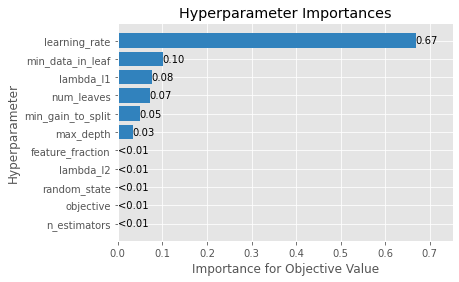

In [34]:
plot_param_importances(study)

In [35]:
best_params = study.best_params
lgb_optuna = LGBMRegressor(**best_params)
lgb_optuna.fit(X_train_,
               y_train_,
               eval_metric="mae",
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='LGBoost_Optuna'))

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] feature_fraction is set=0.8475778638335757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475778638335757
[LightGBM] [Warning] min_data_in_leaf is set=380, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=380
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=1.101783637560498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.101783637560498
[LightGBM] [Warning] lambda_l2 is set=88.40152751272505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.40152751272505


,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,2358.143,1.279424e+07,3576.904,None,0.865,4.691,51.372,17.325
CatBoostRegressor_baseline,2010.398,1.433766e+07,3786.510,None,0.849,-9.227,24.347,14.770
LGBMRegressor_baseline,1688.746,1.032078e+07,3212.598,None,0.891,-8.476,21.820,12.407
LGBoost_Optuna,1594.139,9.634541e+06,3103.956,None,0.899,-8.051,20.892,11.712


#### CatBoostRegressor

In [36]:
from catboost import Pool


cat_feat = X_train.select_dtypes('category').columns.tolist()

# целевая функция
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True), 
        "max_depth": trial.suggest_int("max_depth", 3, 15),
       
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        'loss_function': trial.suggest_categorical("loss_function", ['MAE']),
        "eval_metric": trial.suggest_categorical("eval_metric", ['MAE']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "allow_writing_files": trial.suggest_categorical("allow_writing_files", [False])
    }
    
    

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)
        
        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [37]:
study_cat = optuna.create_study(direction="minimize", study_name="Cat_02")


def func_cat(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND,
                         cat_feat=cat_feat)


study_cat.optimize(func_cat, n_trials=3, show_progress_bar=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
study_cat.best_params

{'n_estimators': 300,
 'learning_rate': 0.0772018738511954,
 'max_depth': 6,
 'use_best_model': True,
 'loss_function': 'MAE',
 'eval_metric': 'MAE',
 'random_state': 10,
 'allow_writing_files': False}

In [39]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
cat_optuna.fit(X_train_,
               y_train_,
               cat_features=cat_features,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = cat_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='CatBoostRegressor_Optuna'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,2358.143,1.279424e+07,3576.904,None,0.865,4.691,51.372,17.325
CatBoostRegressor_baseline,2010.398,1.433766e+07,3786.510,None,0.849,-9.227,24.347,14.770
LGBMRegressor_baseline,1688.746,1.032078e+07,3212.598,None,0.891,-8.476,21.820,12.407
LGBoost_Optuna,1594.139,9.634541e+06,3103.956,None,0.899,-8.051,20.892,11.712
CatBoostRegressor_Optuna,2073.659,1.542567e+07,3927.553,None,0.838,-9.296,24.890,15.235


### Важность признаков

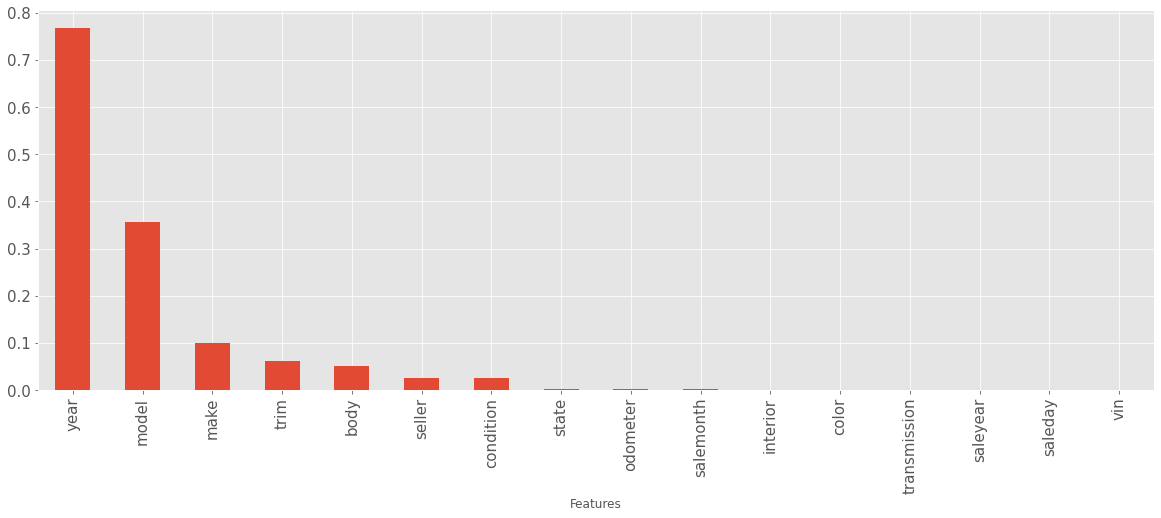

In [40]:
from sklearn.inspection import permutation_importance


r = permutation_importance(lgb_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

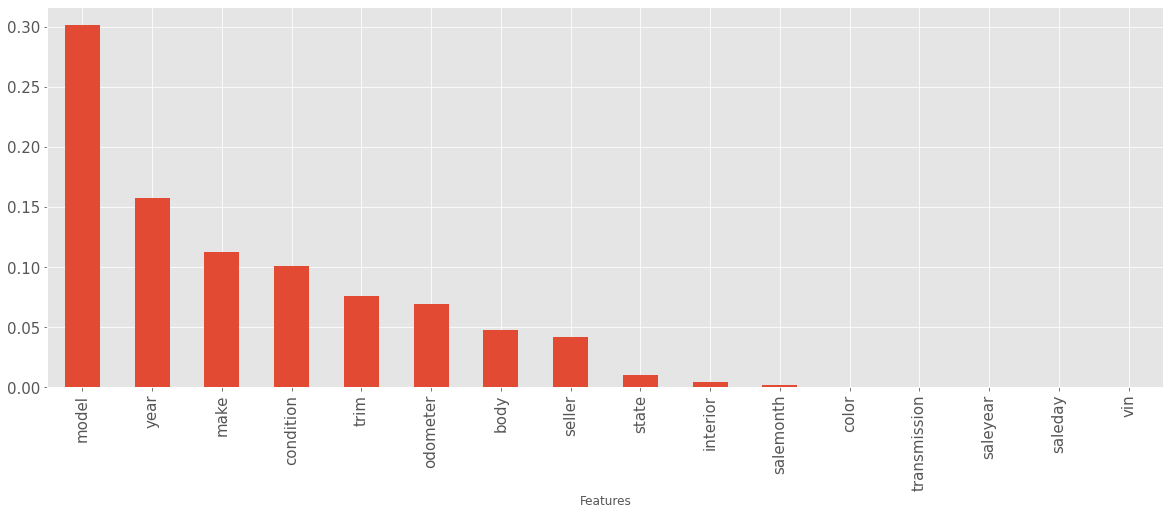

In [41]:
r = permutation_importance(cat_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Применение модели

In [42]:
cols_cat = test.select_dtypes(['object']).columns
test[cols_cat] = test[cols_cat].astype('category')
X_test = test
y_pred = lgb_optuna.predict(X_test)


In [43]:
test['sellingprice'] = y_pred

In [44]:
test.head(10)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saleyear,salemonth,saleday,sellingprice
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,2005,silver,black,lexus of stevens creek,2015,1,13,4348.532743
1,2014,gmc,savana cargo,2500,van,unkn,1gtw7fca7e1902207,pa,4.4,2014,white,gray,u-haul,2015,2,26,18479.270723
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,2013,gray,black,nissan-infiniti lt,2015,2,23,16191.471036
3,2013,chevrolet,impala,ls fleet,sedan,automatic,2g1wf5e34d1160703,fl,2.3,2013,silver,black,onemain rem/auto club of miami inc dba north dad,2015,3,5,8342.337892
4,2013,nissan,titan,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,2013,black,black,nissan north america inc.,2015,6,2,22161.756090
5,2003,volkswagen,passat,gls 1.8t,wagon,automatic,wvwvd63b93e175638,nc,2.4,2003,silver,black,fred anderson nissan of fayetteville,2015,6,8,1431.403263
6,2013,hyundai,sonata,gls,sedan,automatic,5npeb4ac4dh809686,il,3.7,2013,silver,gray,merchants leasing,2015,3,2,11127.812470
7,2013,ford,explorer,base,suv,automatic,1fm5k7b97dgb16454,nc,3.2,2013,black,gray,ge fleet services for itself/servicer,2015,2,9,14490.757842
8,2011,infiniti,g sedan,g37x,g sedan,automatic,jn1cv6ar5bm411441,tn,3.5,2011,black,beige,nissan infiniti lt,2015,2,3,15880.339146
9,2007,chevrolet,suburban,1500 ls,suv,automatic,3gnfc16j77g158033,ga,3.4,2007,black,tan,riverside chevrolet inc,2015,2,9,9573.487103


In [45]:
final_data = test[['vin','sellingprice']].copy()
final_data = final_data.set_index('vin')

In [46]:
final_data.head(20)

,sellingprice
vin,
1g6dp567450124779,4348.532743
1gtw7fca7e1902207,18479.270723
jn8az1mw6dw303497,16191.471036
2g1wf5e34d1160703,8342.337892
1n6aa0ec3dn301209,22161.756090
wvwvd63b93e175638,1431.403263
5npeb4ac4dh809686,11127.812470
1fm5k7b97dgb16454,14490.757842
jn1cv6ar5bm411441,15880.339146


### Общий вывод

Фреймворк LGBMRegressor, который предоставляет реализацию деревьев принятия решений с градиентным бустингом, справляется с поставленной задачей лучше и быстрее всего. Итоговое значение MAPE на тестовой выборке датасета train после подбора оптимальных параметров равно 20.892. Наиболее значимыми являются признаки year, model, make, trim, body, seller и condition (перечислены по уменьшению уровня значимости).